In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

# Project Description

> **DESCRIPTION:** blah blah blah

> **AUTHOR:** Neal Gilmore  
> **DATE:** 27-08-2020

## STEP 1: Environment Preparation (Top)

### 1.1 Import required libraries (Top)

In [1]:
# System libraries
import os
import sys
import time
import warnings
import random

# Standard libraries
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
from sklearn.model_selection import train_test_split

# Turn off Depreciation and Future warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

if not sys.warnoptions:
    warnings.simplefilter('ignore')

%matplotlib inline

print('>> Required libraries imported')

>> Required libraries imported


### 1.2 Prepare for reproducability (Top)

In [2]:
# Set random seed to maintain reproducability
random_state = np.random.seed(42)

# Set the plotting style
plt.style.use('seaborn-whitegrid')

sns.set(style="whitegrid", palette="Blues", color_codes=True, font='sans-serif', font_scale=1.5)

# Force display of all columns in dataframes
pd.options.display.max_columns = None

## STEP 2: Data Preparation (Top)

### 2.1 Import data (Top)

In [3]:
# Import the dataset

# set the data working directory
os.chdir(os.path.join(os.getcwd(), "..", "data", "raw"))

# Set the name of the file
filename = 'loan_data_2007_2014.csv'

# Read the data into memory as dask dataframe for speed
%time df_backup = dd.read_csv(filename)

# Create an initial copy of the data for processing
%time df = df_backup.copy()

# Convert dask dataframe to pandas dataframe
%time df = df.compute()

print('\n>> {} data successfully imported'.format(filename))

# set the model working directory
os.chdir(os.path.join(os.getcwd(), "..", "..", "notebooks"))

CPU times: user 13.4 ms, sys: 3.3 ms, total: 16.7 ms
Wall time: 17.5 ms
CPU times: user 210 µs, sys: 8 µs, total: 218 µs
Wall time: 214 µs
CPU times: user 5.26 s, sys: 1.06 s, total: 6.32 s
Wall time: 3.66 s

>> loan_data_2007_2014.csv data successfully imported


### 2.2 Summary statistics (Top)

In [4]:
# Describe the shape of the data
print("\nNumber of rows in the raw data: {}".format(df.shape[0]))
print("Number of columns in the raw data: {}\n".format(df.shape[1]))


Number of rows in the raw data: 466285
Number of columns in the raw data: 75



In [5]:
# Describe the df; Round values to 2 decimals
print(np.round(df.describe(), 2).T)

                                count         mean          std       min  \
Unnamed: 0                   466285.0    233142.00    134605.03      0.00   
id                           466285.0  13079729.91  10893711.62  54734.00   
member_id                    466285.0  14597660.62  11682367.44  70473.00   
loan_amnt                    466285.0     14317.28      8286.51    500.00   
funded_amnt                  466285.0     14291.80      8274.37    500.00   
funded_amnt_inv              466285.0     14222.33      8297.64      0.00   
int_rate                     466285.0        13.83         4.36      5.42   
installment                  466285.0       432.06       243.49     15.67   
annual_inc                   466281.0     73277.38     54963.57   1896.00   
dti                          466285.0        17.22         7.85      0.00   
delinq_2yrs                  466256.0         0.28         0.80      0.00   
inq_last_6mths               466256.0         0.80         1.09      0.00   

In [6]:
# Identify column datatypes
print(df.dtypes)

list(set(df.dtypes.tolist()))

Unnamed: 0            int64
id                    int64
member_id             int64
loan_amnt             int64
funded_amnt           int64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 75, dtype: object


[dtype('int64'), dtype('float64'), dtype('O')]

In [33]:
# View the head of the data
print(df.head())

   Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade sub_grade  \
0   36 months     10.65       162.87     B        B2   
1   60 months     15.27        59.83     C        C4   
2   36 months     15.96        84.33     C        C5   
3   36 months     13.49       339.31     C        C1   
4   60 months     12.69        67.79     B        B5   

                  emp_title emp_length home_ownership  annual_inc  \
0                       NaN  10+ years           RENT     24000.0   
1                     Ryder   < 1 year           RENT   

In [34]:
# View the tail of the data
print(df.tail())

        Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
100358      466280  8598660    1440975      18400        18400   
100359      466281  9684700   11536848      22000        22000   
100360      466282  9584776   11436914      20700        20700   
100361      466283  9604874   11457002       2000         2000   
100362      466284  9199665   11061576      10000        10000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
100358          18400.0   60 months     14.47       432.64     C        C2   
100359          22000.0   60 months     19.97       582.50     D        D5   
100360          20700.0   60 months     16.99       514.34     D        D1   
100361           2000.0   36 months      7.90        62.59     A        A4   
100362           9975.0   36 months     19.20       367.58     D        D3   

                                    emp_title emp_length home_ownership  \
100358                     Financial Advisor     4 years   

In [9]:
df.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 100362
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

## STEP 3: Data Pre-processing (Top)¶

### 3.1 Pre-process continuous variables (Top)

Convert employment length to float

In [11]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [12]:
df['emp_length_int'] = df['emp_length'].str.replace('\+ years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('< 1 year', str(0))
df['emp_length_int'] = df['emp_length_int'].str.replace('n/a', str(0))
df['emp_length_int'] = df['emp_length_int'].str.replace(' years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace(' year', '')

In [13]:
df['emp_length_int'].dtypes

dtype('O')

In [14]:
df['emp_length_int'] = pd.to_numeric(df['emp_length_int'])

In [15]:
df['emp_length_int'].dtypes

dtype('float64')

Convert dates to proper date format

In [16]:
df['earliest_cr_line']

0         Jan-85
1         Apr-99
2         Nov-01
3         Feb-96
4         Jan-96
           ...  
100358    Apr-03
100359    Jun-97
100360    Dec-01
100361    Feb-03
100362    Feb-00
Name: earliest_cr_line, Length: 466285, dtype: object

In [17]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [18]:
df['earliest_cr_line_date']

0        1985-01-01
1        1999-04-01
2        2001-11-01
3        1996-02-01
4        1996-01-01
            ...    
100358   2003-04-01
100359   1997-06-01
100360   2001-12-01
100361   2003-02-01
100362   2000-02-01
Name: earliest_cr_line_date, Length: 466285, dtype: datetime64[ns]

Calculate delta between earliest credit line and TODAY

In [19]:
pd.to_datetime('2017-12-01') - df['earliest_cr_line_date']

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
100358    5358 days
100359    7488 days
100360    5844 days
100361    5417 days
100362    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [20]:
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [21]:
df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [22]:
df.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][df['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
...,...,...,...
98081,Jan-68,2068-01-01,-601.0
98338,Jul-66,2066-07-01,-583.0
99178,Oct-67,2067-10-01,-598.0
99578,Sep-67,2067-09-01,-597.0


In [23]:
df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()

In [24]:
min(df['mths_since_earliest_cr_line'])

73.0

In [25]:
# do the same for term and issue_date

Convert term to int

In [26]:
df['term']

0          36 months
1          60 months
2          36 months
3          36 months
4          60 months
             ...    
100358     60 months
100359     60 months
100360     60 months
100361     36 months
100362     36 months
Name: term, Length: 466285, dtype: object

In [27]:
df['term'].describe()

count         466285
unique             2
top        36 months
freq          337953
Name: term, dtype: object

In [28]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [29]:
df['term_int'] = df['term'].str.replace(' months', '')

In [30]:
df['term_int'].dtypes

dtype('O')

In [31]:
df['term_int'] = pd.to_numeric(df['term_int'])

In [32]:
df['term_int'].dtypes

dtype('int64')

Clean issue date column (issue_d)

In [33]:
df['issue_d']

0         Dec-11
1         Dec-11
2         Dec-11
3         Dec-11
4         Dec-11
           ...  
100358    Jan-14
100359    Jan-14
100360    Jan-14
100361    Jan-14
100362    Jan-14
Name: issue_d, Length: 466285, dtype: object

In [34]:
# Assume we are now in December 2017
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')
# Extracts the date and the time from a string variable that is in a given format

df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['issue_d_date']) / np.timedelta64(1, 'M')))
# We calculate the difference between two dates in months, turn it to numeric datatype and round it
# We save the result in a new variable.

df['mths_since_issue_d'].describe()
# Shows some descriptive statisics for the values of a column

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

### 3.2 Pre-process discrete variables (Top)

Grade

In [35]:
pd.get_dummies(df['grade'])

,A,B,C,D,E,F,G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
100358,0,0,1,0,0,0,0
100359,0,0,0,1,0,0,0
100360,0,0,0,1,0,0,0
100361,1,0,0,0,0,0,0


In [36]:
pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = ': ')

,grade: A,grade: B,grade: C,grade: D,grade: E,grade: F,grade: G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
100358,0,0,1,0,0,0,0
100359,0,0,0,1,0,0,0
100360,0,0,0,1,0,0,0
100361,1,0,0,0,0,0,0


In [37]:
df_dummies = [pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = ': '),
             pd.get_dummies(df['sub_grade'], prefix = 'sub_grade', prefix_sep = ': '),
             pd.get_dummies(df['home_ownership'], prefix = 'home_ownership', prefix_sep = ': '),
             pd.get_dummies(df['verification_status'], prefix = 'verification_status', prefix_sep = ': '),
             pd.get_dummies(df['loan_status'], prefix = 'loan_status', prefix_sep = ': '),
             pd.get_dummies(df['purpose'], prefix = 'purpose', prefix_sep = ': '),
             pd.get_dummies(df['addr_state'], prefix = 'addr_state', prefix_sep = ': '),
             pd.get_dummies(df['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ': ')]

In [38]:
df_dummies = pd.concat(df_dummies, axis = 1)

In [39]:
df = pd.concat([df, df_dummies], axis = 1)

In [40]:
df.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

### 3.3 Pre-process missing data (Top)

In [41]:
df.isnull()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade: A,grade: B,grade: C,grade: D,grade: E,grade: F,grade: G,sub_grade: A1,sub_grade: A2,sub_grade: A3,sub_grade: A4,sub_grade: A5,sub_grade: B1,sub_grade: B2,sub_grade: B3,sub_grade: B4,sub_grade: B5,sub_grade: C1,sub_grade: C2,sub_grade: C3,sub_grade: C4,sub_grade: C5,sub_grade: D1,sub_grade: D2,sub_grade: D3,sub_grade: D4,sub_grade: D5,sub_grade: E1,sub_grade: E2,sub_grade: E3,sub_grade: E4,sub_grade: E5,sub_grade: F1,sub_grade: F2,sub_grade: F3,sub_grade: F4,sub_grade: F5,sub_grade: G1,sub_grade: G2,sub_grade: G3,sub_grade: G4,sub_grade: G5,home_ownership: ANY,home_ownership: MORTGAGE,home_ownership: NONE,home_ownership: OTHER,home_ownership: OWN,home_ownership: RENT,verification_status: Not Verified,verification_status: Source Verified,verification_status: Verified,loan_status: Charged Off,loan_status: Current,loan_status: Default,loan_status: Does not meet the credit policy. Status:Charged Off,loan_status: Does not meet the credit policy. Status:Fully Paid,loan_status: Fully Paid,loan_status: In Grace Period,loan_status: Late (16-30 days),loan_status: Late (31-120 days),purpose: car,purpose: credit_card,purpose: debt_consolidation,purpose: educational,purpose: home_improvement,purpose: house,purpose: major_purchase,purpose: medical,purpose: moving,purpose: other,purpose: renewable_energy,purpose: small_business,purpose: vacation,purpose: wedding,addr_state: AK,addr_state: AL,addr_state: AR,addr_state: AZ,addr_state: CA,addr_state: CO,addr_state: CT,addr_state: DC,addr_state: DE,addr_state: FL,addr_state: GA,addr_state: HI,addr_state: IA,addr_state: ID,addr_state: IL,addr_state: IN,addr_state: KS,addr_state: KY,addr_state: LA,addr_state: MA,addr_state: MD,addr_state: ME,addr_state: MI,addr_state: MN,addr_state: MO,addr_state: MS,addr_state: MT,addr_state: NC,addr_state: NE,addr_state: NH,addr_state: NJ,addr_state: NM,addr_state: NV,addr_state: NY,addr_state: OH,addr_state: OK,addr_state: OR,addr_state: PA,addr_state: RI,addr_state: SC,addr_state: SD,addr_state: TN,addr_state: TX,addr_state: UT,addr_state: VA,addr_state: VT,addr_state: WA,addr_state: WI,addr_state: WV,addr_state: WY,initial_list_status: f,initial_list_status: w
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [42]:
pd.options.display.max_rows = None
df.isnull().sum()

Unnamed: 0                                                               0
id                                                                       0
member_id                                                                0
loan_amnt                                                                0
funded_amnt                                                              0
funded_amnt_inv                                                          0
term                                                                     0
int_rate                                                                 0
installment                                                              0
grade                                                                    0
sub_grade                                                                0
emp_title                                                            27588
emp_length                                                           21008
home_ownership           

In [43]:
pd.options.display.max_rows = 100

In [44]:
df['total_rev_hi_lim'].fillna(df['funded_amnt'], inplace = True)

In [45]:
df['total_rev_hi_lim'].isnull().sum()

0

In [46]:
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)

In [47]:
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['acc_now_delinq'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)

## STEP 4: Probability of Default (PD) Model Data Preparation (Top)

### 4.1 Define dependent variable - Default / Non-Default accounts (Top)

In [48]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [49]:
df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [50]:
df['loan_status'].value_counts() / df['loan_status'].count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [51]:
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 
                                                  'Does not meet the credit policy. Status:Charged Off', 
                                                 'Late (31-120 days)']),0, 1)

In [52]:
df['good_bad']

0         1
1         0
2         1
3         1
4         1
         ..
100358    1
100359    0
100360    1
100361    1
100362    1
Name: good_bad, Length: 466285, dtype: int32

## STEP 5: Feature Engineering (Top)¶

### 5.1 Determine information value of categorical variables (Top)

**Weight of Evidence:** (The extent to which a categorically independent variable explains the difference of a categorical outcome variable)

$$
\text{WoE}_{i} = \text{ln} \left( \frac{\%(y = 1)_{i}}{\%(y = 0)_{i}} \right) = \text{ln} \left( \frac{\%\text{good}_{i}}{\%\text{bad}_{i}} \right)
$$

**Information Value:** How much information the original independent variable brings with respect to explaining the dependent variable (Range of 0->1)

$$
\text{Information Value} = \sum_{i=1}^{k} \left[(\% \text{good} - \% \text{bad}) X \text{ln} \left( \frac{\%\text{good}}{\%\text{bad}} \right) \right]
$$

| Information Value Range: 0 - 1 | Predictive Powers |
|--- |----------| 
| IV < 0.02 | No predictive power |
| 0.02 < IV < 0.1 | Weak predictive power |
| 0.1 < IV < 0.3 | Medium predictive power |
| 0.3 < IV < 0.5 | Strong predictive power |
| 0.5 < IV | Suspiciously high, likely too good to be true |

**Example:** Education Variable

| Variable Categories | Good | Bad | Proportion Good | Proportion Bad | Weight of Evidence | % Good - % Bad |  |
| ---------- | ---- | --- | ---------- | ---------- | ---------- | ---------- | --------- |
| Higher Education | 4,000 | 600 | 25% | 15% | 0.51 | 0.1 | 0.0511 |
| No Higher Education | 12,000 | 3,400 | 75% | 85% | -0.13 | -0.1 | 0.0125 |
|  | 16,000 | 4,000 | 100% | 100% |  | **Information Value** | **0.0636** |

## STEP 6: Prepare Data for Modeling (Top)¶

### 6.1 Split training and test data (Top)

In [53]:
#train_test_split(df.drop('good_bad', axis = 1), df['good_bad'])

In [54]:
# Create the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(df.drop('good_bad', axis = 1), df['good_bad'], 
                                                    test_size = 0.20,
                                                    random_state = random_state)

In [55]:
X_train.shape

(373028, 207)

In [56]:
y_train.shape

(373028,)

In [57]:
X_test.shape

(93257, 207)

In [58]:
y_test.shape

(93257,)

In [59]:
df_inputs_preproc = X_train
df_targets_preproc = y_train

In [60]:
df_inputs_preproc['grade'].unique()

array(['A', 'C', 'D', 'B', 'E', 'F', 'G'], dtype=object)

### 6.2 Calculate Weight of Evidence (WoE) of Discrete Variables (Top)

In [61]:
def woe_discrete(df, discrete_var_name, good_bad_var_df):
    df = pd.concat([df[discrete_var_name], good_bad_var_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(), 
                df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()],
               axis = 1)
    # Keep only required columns
    df = df.iloc[: , [0, 1, 3]]
    # Rename columns
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    # Calculate proportion of observations from total number of observations
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    # CaLculate the number of good and bad borrowers
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    # Calculate the proportion of good and bad borrowers from the total number of borrowers
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    # Calculate the weight of evidence
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    # Sort by weight of evidence and reset the index
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    # Calculate the differences in proportion of good loans and weight of evidence
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    # Calculate the information value
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    return df

In [62]:
df_temp = woe_discrete(df_inputs_preproc, 'grade', df_targets_preproc)

In [63]:
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2654,0.731349,0.007115,1941.0,713.0,0.005830,0.017772,-1.114542,NaN,NaN,0.285803
1,F,10530,0.757455,0.028228,7976.0,2554.0,0.023958,0.063661,-0.977243,0.026106,0.137299,0.285803
2,E,28612,0.808996,0.076702,23147.0,5465.0,0.069530,0.136220,-0.672518,0.051541,0.304725,0.285803
3,D,61498,0.848873,0.164862,52204.0,9294.0,0.156812,0.231661,-0.390229,0.039877,0.282289,0.285803
4,C,100245,0.887845,0.268733,89002.0,11243.0,0.267346,0.280241,-0.047106,0.038972,0.343123,0.285803
5,B,109730,0.922118,0.294160,101184.0,8546.0,0.303939,0.213016,0.355458,0.034273,0.402564,0.285803
6,A,59759,0.961445,0.160200,57455.0,2304.0,0.172585,0.057429,1.100336,0.039327,0.744878,0.285803


### 6.3 Data visualization of Weight of Evidence (WoE) of Categorical Variables (Top)

In [87]:
def plot__by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    
    plt.figure(figsize = (18, 6))
    plt.plot(x, 
             y, 
             marker = 'o', 
             linestyle = '--', 
             #markeredgecolor = 'white',
             color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence (WoE)')
    plt.title(str('Weight of Evidence (WoE) by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

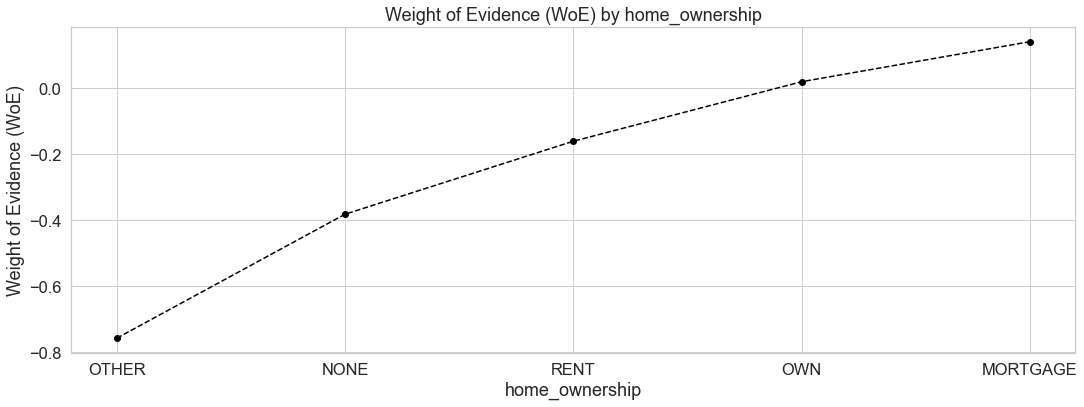

In [88]:
plot__by_woe(df_temp)

### 6.4 Create Dummy Variables (Top)

In [68]:
df_temp = woe_discrete(df_inputs_preproc, 'home_ownership', df_targets_preproc)

In [69]:
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,137,0.795620,0.000367,109.0,28.0,0.000327,0.000698,-0.756876,NaN,NaN,inf
1,NONE,40,0.850000,0.000107,34.0,6.0,0.000102,0.000150,-0.381418,0.054380,0.375458,inf
2,RENT,150599,0.876062,0.403720,131934.0,18665.0,0.396306,0.465241,-0.160367,0.026062,0.221051,inf
3,OWN,33295,0.894338,0.089256,29777.0,3518.0,0.089445,0.087689,0.019824,0.018277,0.180192,inf
4,MORTGAGE,188956,0.905258,0.506546,171054.0,17902.0,0.513816,0.446222,0.141048,0.010920,0.121223,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.094742,inf,inf


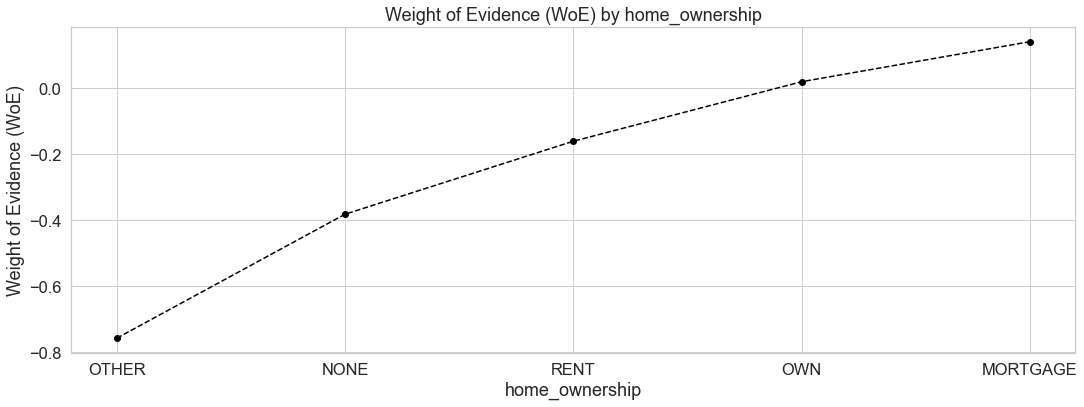

In [70]:
plot__by_woe(df_temp)

In [72]:
# Combine underrepresented categories (Other, None, Any) into Rent
df_inputs_preproc['home ownership: RENT_OTHER_NONE_ANY'] = sum([df_inputs_preproc['home_ownership: RENT'],
                                                              df_inputs_preproc['home_ownership: OTHER'],
                                                              df_inputs_preproc['home_ownership: NONE'],
                                                              df_inputs_preproc['home_ownership: ANY']])